### Data Science Salaries 2024 

## Data Cleaning

The dataset used is the [**Data Science Salaries 2024**](https://www.kaggle.com/datasets/sazidthe1/data-science-salaries), a dataset containing informations such as salary, work model, employment type and more about data scientists in all of the world. The author **Sazidul Islam** has done a great job in cleaning the data, but some minor changes are needed.

First of all, let"s import all the libraries we are gonna use.

In [133]:
#importing libraries
from os import getcwd
#to get the working directory through getcwd
from pandas import *
#to manipulate dataframes
import geopandas as gpd
#for choropleth maps
from plotnine import *
from numpy import *
from plotnine.stats import *
#for data visualization
from statistics import *
#to get all of the statistical functions needed

I downloaded the data and moved it into the working directory. It is in the .csv format, so I"m gonna use the function read_csv to read the file and store it in a pandas dataframe.

In [134]:
path_to_data = getcwd() + r"\data_science_salaries.csv"

data = read_csv(path_to_data, sep = ",")

print("Number of rows: ", len(data))

Number of rows:  6599


In [135]:
data.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


The number of rows is 6599, a really big amount of data. First thing that comes into my eyes, are the capitalized first letters of every word, and the diversity we have in the job_title column.

In [136]:
x = data["job_title"].value_counts()
print(x)
print("\n Sum of Data Engineers, Data Scientists, Data Analyst and ML Engineers: ", sum(x[0:4]))

job_title
Data Engineer                      1307
Data Scientist                     1243
Data Analyst                        910
Machine Learning Engineer           629
Analytics Engineer                  246
                                   ... 
Data Science Tech Lead                1
Staff Machine Learning Engineer       1
Cloud Data Architect                  1
Marketing Data Engineer               1
Sales Data Analyst                    1
Name: count, Length: 132, dtype: int64

 Sum of Data Engineers, Data Scientists, Data Analyst and ML Engineers:  4089


As we can see, there is a huge number of diverse job titles. We will just keep the top four, which represents roughly two thirds of all data, and we will drop all of the other job titles. The first four are **Data Engineer**, **Data Scientists**, **Data Analyst** and **Machine Learning Engineer**. Let"s convert every string column into lower case. 

In [137]:
print(type(data["job_title"].dtype))
print(type(data["work_models"].dtype))
#pandas stores string values under the "ObjectType" 

<class 'numpy.dtypes.ObjectDType'>
<class 'numpy.dtypes.ObjectDType'>


In [138]:
for x in data:
    if data[x].dtype == "object":
        data[x] = data[x].str.lower()
#this is a for loop that checks if a pandas column is of the type "object" (string) and applies the method Series.str.lower to that column.
data.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,data engineer,mid-level,full-time,remote,2024,united states,148100,usd,148100,united states,medium
1,data engineer,mid-level,full-time,remote,2024,united states,98700,usd,98700,united states,medium
2,data scientist,senior-level,full-time,remote,2024,united states,140032,usd,140032,united states,medium
3,data scientist,senior-level,full-time,remote,2024,united states,100022,usd,100022,united states,medium
4,bi developer,mid-level,full-time,on-site,2024,united states,120000,usd,120000,united states,medium


In [139]:
jobs_to_keep = ["data engineer", "data scientist", "data analyst", "machine learning engineer"]
data = data[data["job_title"].isin(jobs_to_keep)]
#boolean indexing. data["job_title"].isin(jobs_to_keep) returns an array of False or True if the job title is in jobs_to_keep.
print(unique(data["job_title"]))

['data analyst' 'data engineer' 'data scientist'
 'machine learning engineer']


In [140]:
data["company_size"]

0       medium
1       medium
2       medium
3       medium
8       medium
         ...  
6589     small
6591     large
6592     small
6597     large
6598     small
Name: company_size, Length: 4089, dtype: object

In [141]:
print("Number of rows: ",len(data))

Number of rows:  4089


As we can see, we have 4089 rows left, which are enough for our purpose. I don"t like the "-level" in every experience_level value, so I"m gonna delete it.

In [142]:
data["experience_level"] = data["experience_level"].str.replace("-level","")
data["experience_level"]

0             mid
1             mid
2          senior
3          senior
8       executive
          ...    
6589          mid
6591          mid
6592        entry
6597          mid
6598       senior
Name: experience_level, Length: 4089, dtype: object

Now let"s check for missing values.

In [143]:
for x in data:
    print(x,":",data[x].hasnans)
#hasnans is an attribute of pandas.Series (pandas columns) that return False if the columns doesn"t have any Nan or True if it has at least one.

job_title : False
experience_level : False
employment_type : False
work_models : False
work_year : False
employee_residence : False
salary : False
salary_currency : False
salary_in_usd : False
company_location : False
company_size : False


There are no missing values. Let"s convert all categorical data to the pandas Categorical type.

In [144]:
data["job_title"] = Categorical(data["job_title"])

ordered_experience_variable = ["entry", "mid", "senior", "executive"]
data["experience_level"] = Categorical(data["experience_level"],ordered = True, categories=ordered_experience_variable)

data["employment_type"] = Categorical(data["employment_type"])

ordered_work_models = ["on-site","hybrid","remote"]
data["work_models"] = Categorical(data["work_models"], ordered = True,categories = ordered_work_models)

data["data_size"] = Categorical(data["work_models"])

ordered_size = ["small", "medium", "large"]
data["company_size"] = Categorical(data["company_size"], ordered = True, categories = ordered_size)

data.dtypes

job_title             category
experience_level      category
employment_type       category
work_models           category
work_year                int64
employee_residence      object
salary                   int64
salary_currency         object
salary_in_usd            int64
company_location        object
company_size          category
data_size             category
dtype: object

In [145]:
counts = data['company_location'].value_counts()

valid_countries = counts[counts >= 10].index

data = data[data['company_location'].isin(valid_countries)]
sum(data['company_location'].value_counts())

np.int64(3951)

## Data Visualization

Let"s set the default theme and colors for our visualizations.

In [146]:
cols = {"data analyst":"#C44E52", "data engineer":"#E5C07B", "data scientist":"#4C72B0", "machine learning engineer":"#55A868"}
theme_set(theme_538())
theme(figure_size = (10,6))

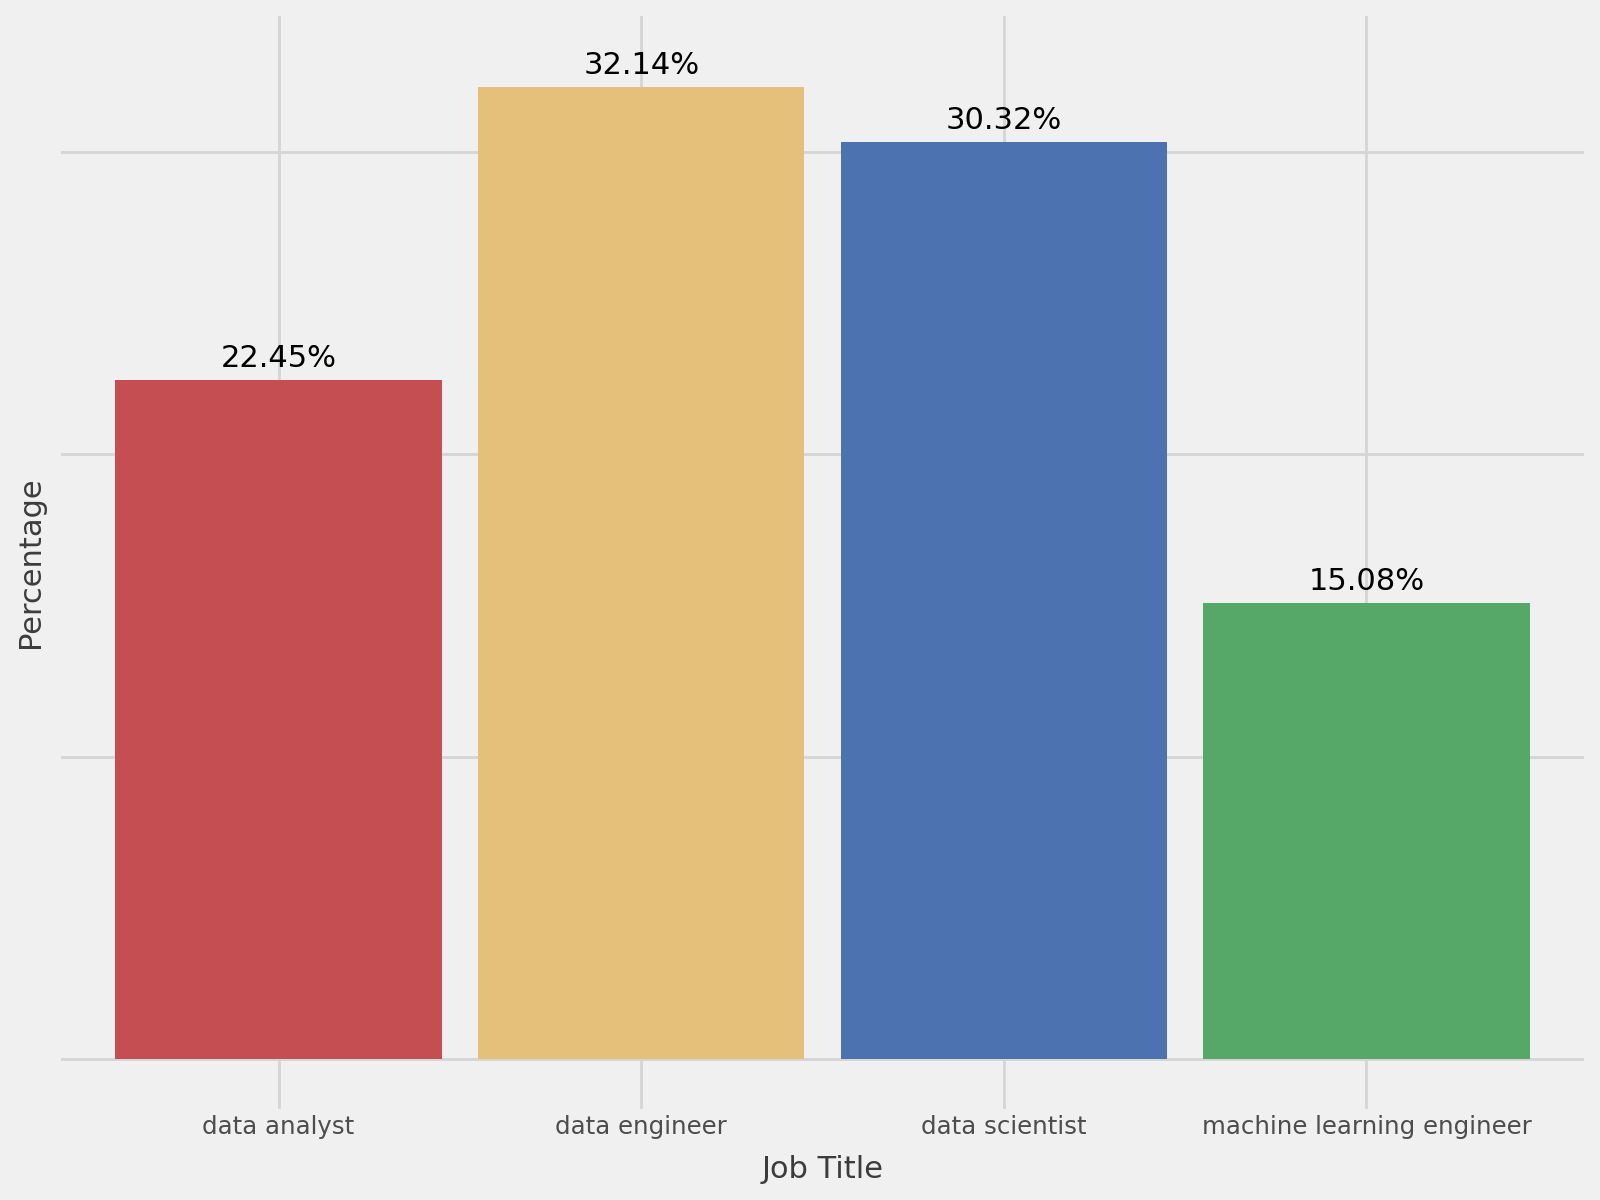

In [147]:
(
    ggplot(data, aes(x = "job_title"))
    + geom_bar(aes(y = after_stat("count / sum(count) *100"), fill = "job_title"))
    + geom_text(aes(y = after_stat("prop*100"), label = after_stat("prop*100"),group = 1),stat = "count", format_string = "{:.2f}%",nudge_y = 0.7)
    + scale_fill_manual(cols, guide = None)
    + labs(y = "Percentage", x = "Job Title")
    + theme(axis_text_y=element_blank(),axis_ticks_y=element_blank(), figure_size = (8,6))
)

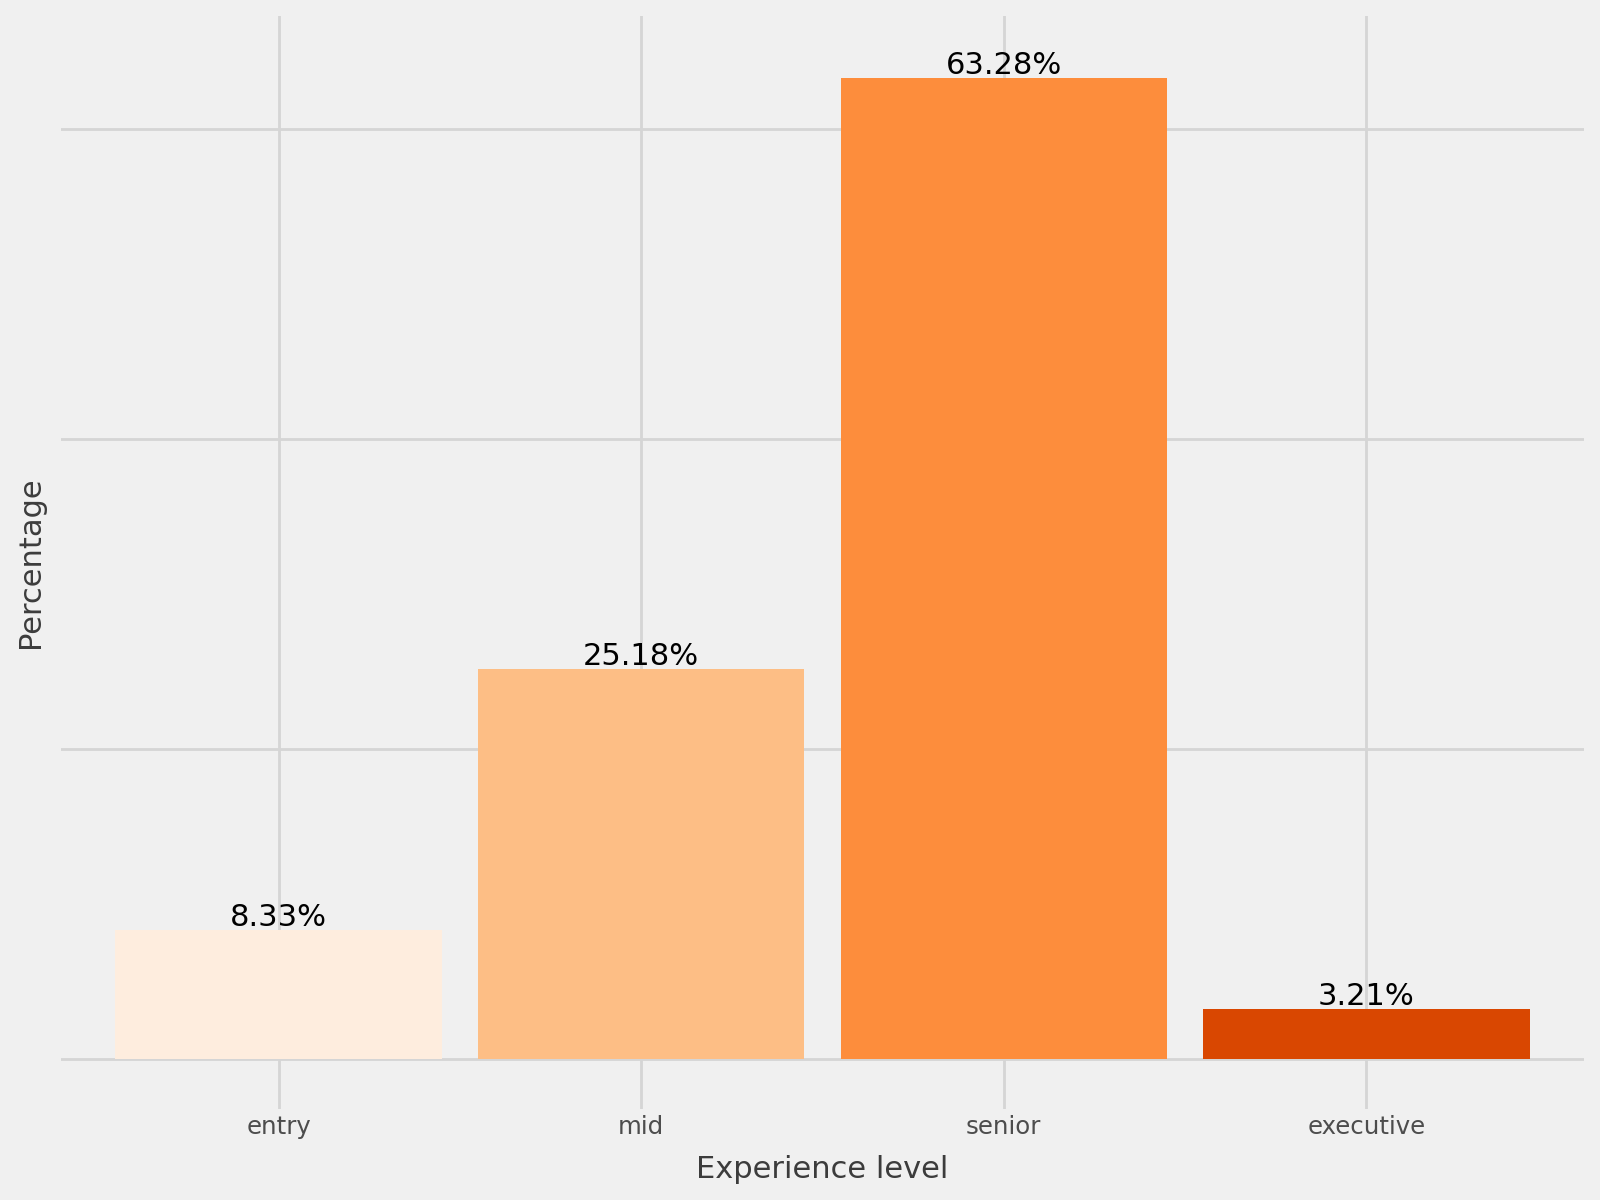

In [148]:
(
    ggplot(data, aes(x="experience_level",fill = "experience_level"))
    + geom_bar(aes(y = after_stat("count / sum(count)*100")))
    + geom_text(aes(y = after_stat("prop * 100"), label = after_stat("prop *100"),group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 0.8)
    + scale_fill_brewer(palette="Oranges",guide = None)
    + labs(y="Percentage", x = "Experience level")
    + theme(axis_ticks_x=element_blank(),axis_ticks_y=element_blank(),axis_text_y=element_blank(), figure_size=(8,6))
)

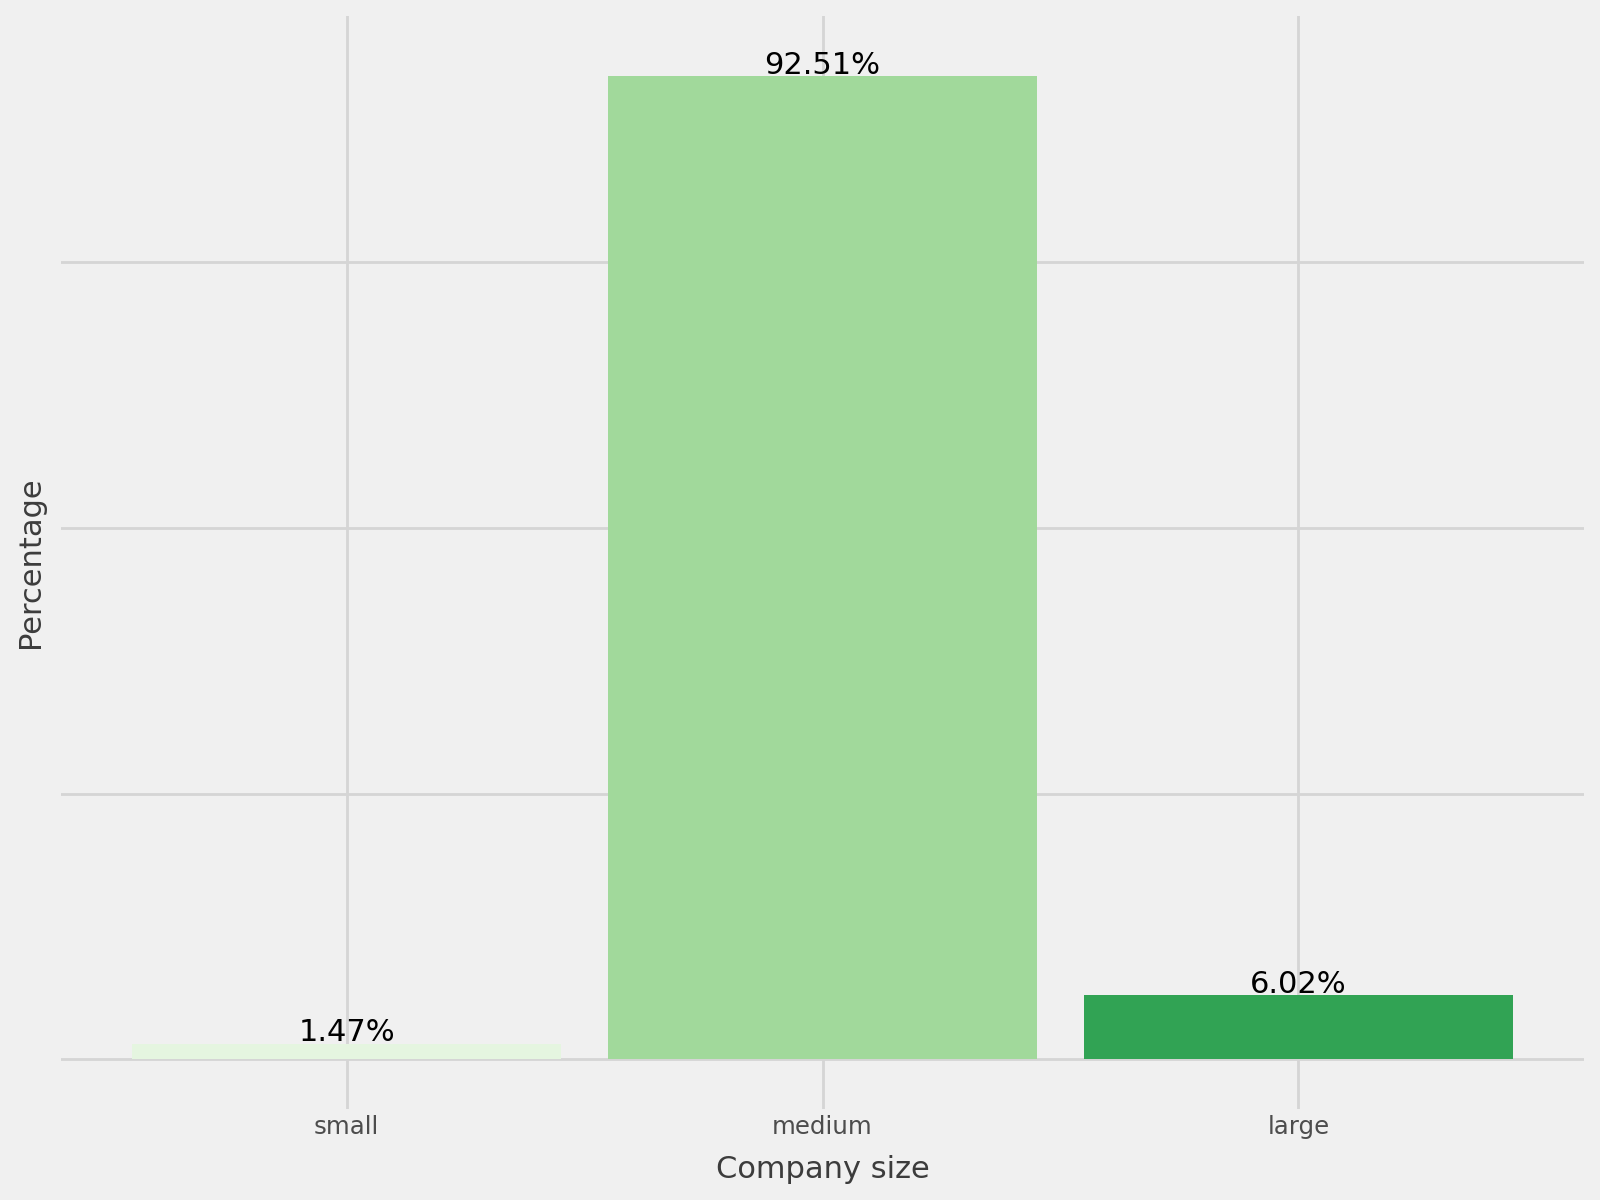

In [149]:
(
    ggplot(data, aes(x = "company_size", fill = "company_size"))
    + geom_bar(aes(y = after_stat("count / sum(count) *100")), stat = "count")
    + geom_text(aes(y = after_stat("prop * 100"), label = after_stat("prop *100"),group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 1)
    + scale_fill_brewer(palette = "Greens",guide = None)
    + theme(axis_ticks_y=element_blank(),axis_text_y=element_blank(), figure_size=(8,6))
    + labs(y="Percentage", x = "Company size")
)

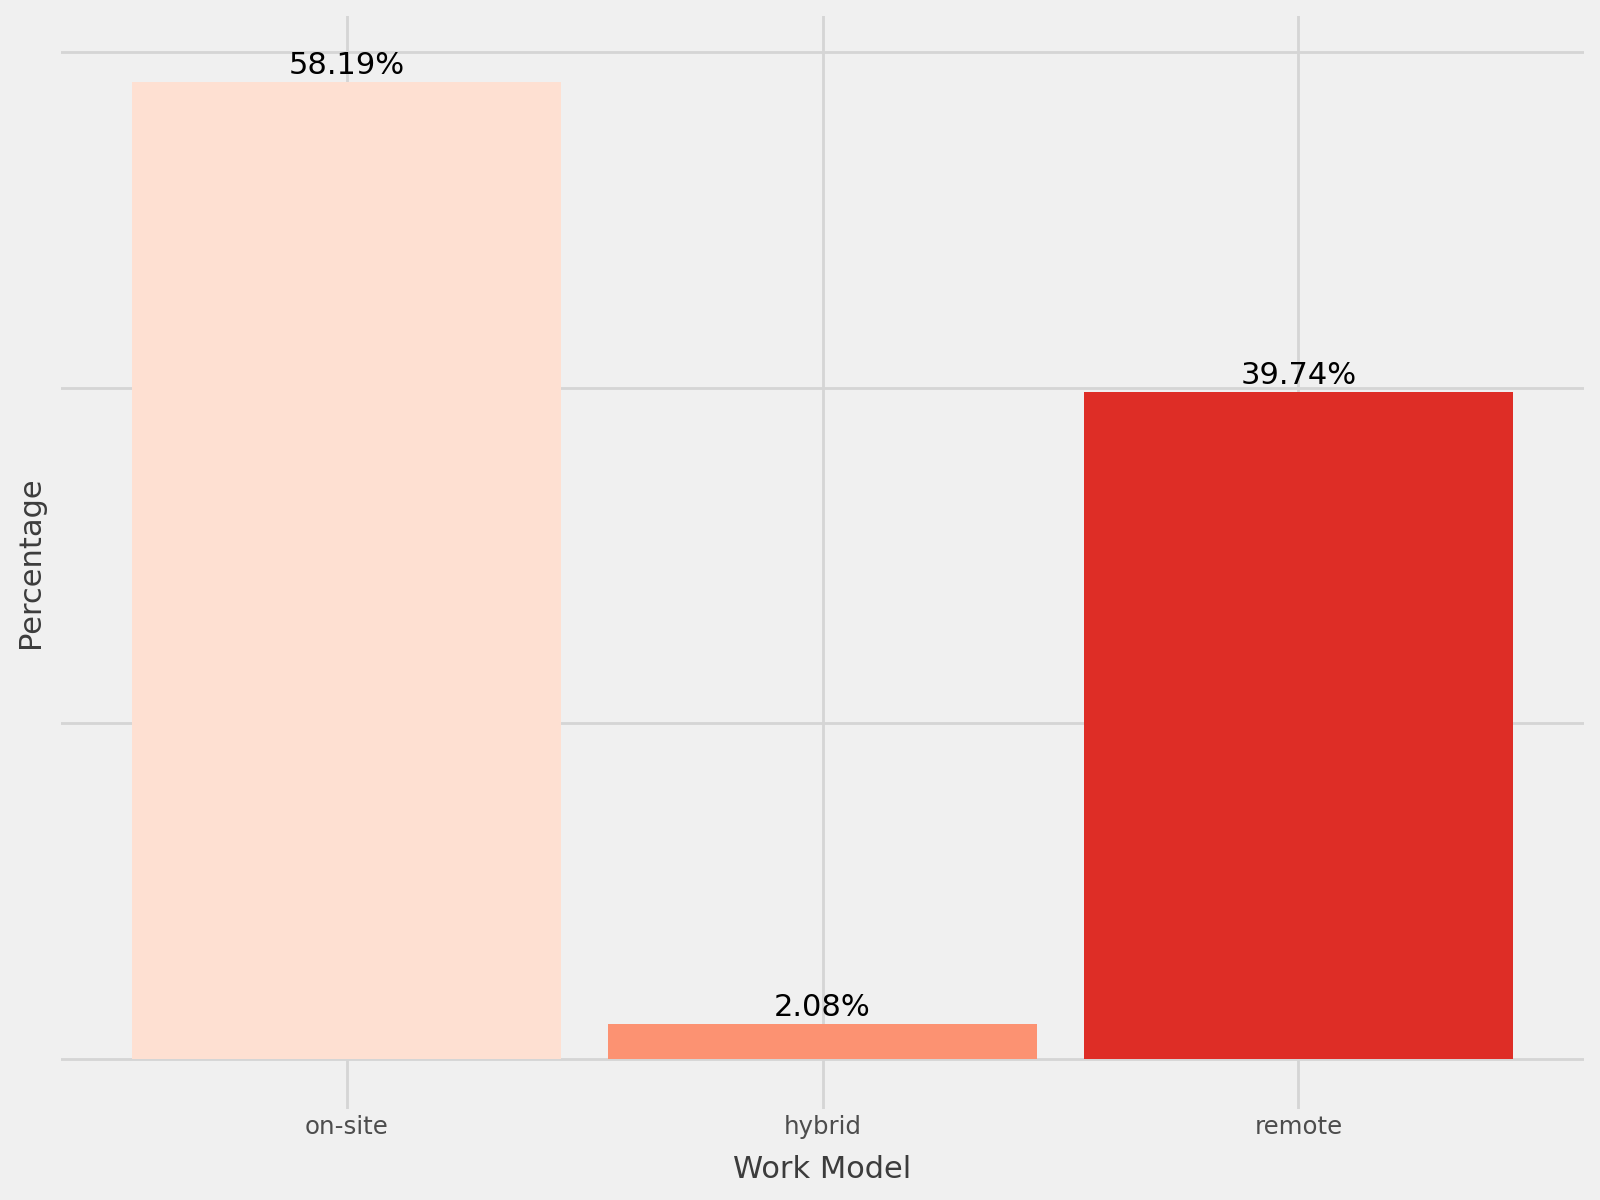

In [150]:
(
    ggplot(data, aes(x = "work_models", fill = "work_models"))
    + geom_bar(aes(y = after_stat("count / sum(count) * 100")), stat = "count")
    + geom_text(aes(y = after_stat("prop*100"), label = after_stat("prop *100"), group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 1)
    + scale_fill_brewer(palette="Reds",guide = None)
    + labs(x = "Work Model", y = "Percentage")
    + theme(figure_size=(8,6), axis_ticks_y=element_blank(), axis_text_y=element_blank())
)

In [151]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)
gdf

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Admin-0 country,1,5,Republic of Serbia,SRB,0,2,Sovereign country,1,Republic of Serbia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Admin-0 country,1,6,Montenegro,MNE,0,2,Sovereign country,1,Montenegro,...,None,None,None,None,None,None,None,None,None,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,Admin-0 country,1,6,Kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Admin-0 country,1,5,Trinidad and Tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


In [152]:
from thefuzz import process
data["matched_name"] = data["company_location"].apply(lambda x: process.extractOne(x, gdf["ADMIN"])[0])

In [153]:
unique(gdf["ADMIN"])

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia',
       'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Democratic Republic of the Congo', 'Denmark',
       'Djibouti', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Falkland Islands', 'Fiji', 'Finland', 'France',
       'French Southern and Antarctic Lands', 'Gabon', 'Gambia',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras',
       'Hungary', 'Iceland', 'India

In [154]:
for x in unique(data["company_location"]):
    a = process.extractOne(x,gdf["ADMIN"])[0]
    print(x,"|",a)

australia | Australia
canada | Canada
colombia | Colombia
france | France
germany | Germany
india | India
netherlands | Netherlands
portugal | Portugal
spain | Spain
united kingdom | United Kingdom
united states | United States of America


In [155]:
data = data[~data["company_location"].isin(["andorra", "hong kong", "malta", "singapore"])]
#deleting rows which company location is in the list above
data.loc[(data["company_location"] == "puerto rico"),"matched_name"] = "United States of America"
print(data.loc[data["company_location"] == "puerto rico"]["matched_name"])


Series([], Name: matched_name, dtype: object)


In [156]:
gdf = gdf.loc[:,["ADMIN","geometry"]]

data = merge(data, gdf, left_on = "matched_name", right_on = "ADMIN", how = "left")

In [174]:
salary_median = data.groupby("matched_name")["salary_in_usd"].median().reset_index()
salary_median

,matched_name,salary_in_usd
0,Australia,104563.5
1,Canada,140000.0
2,Colombia,72000.0
3,France,64781.0
4,Germany,65013.0
5,India,24342.0
6,Netherlands,69741.0
7,Portugal,55812.5
8,Spain,49508.5
9,United Kingdom,86193.0


In [158]:
salary_median = merge(salary_median,gdf.loc[:,"ADMIN":"geometry"], how = "right", left_on = "matched_name", right_on = "ADMIN")
salary_median


,salary_in_usd,ADMIN,geometry
0,NaN,Fiji,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,NaN,United Republic of Tanzania,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,NaN,Western Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,140000.0,Canada,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,145000.0,United States of America,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...
172,NaN,Republic of Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,NaN,Montenegro,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,NaN,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,NaN,Trinidad and Tobago,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


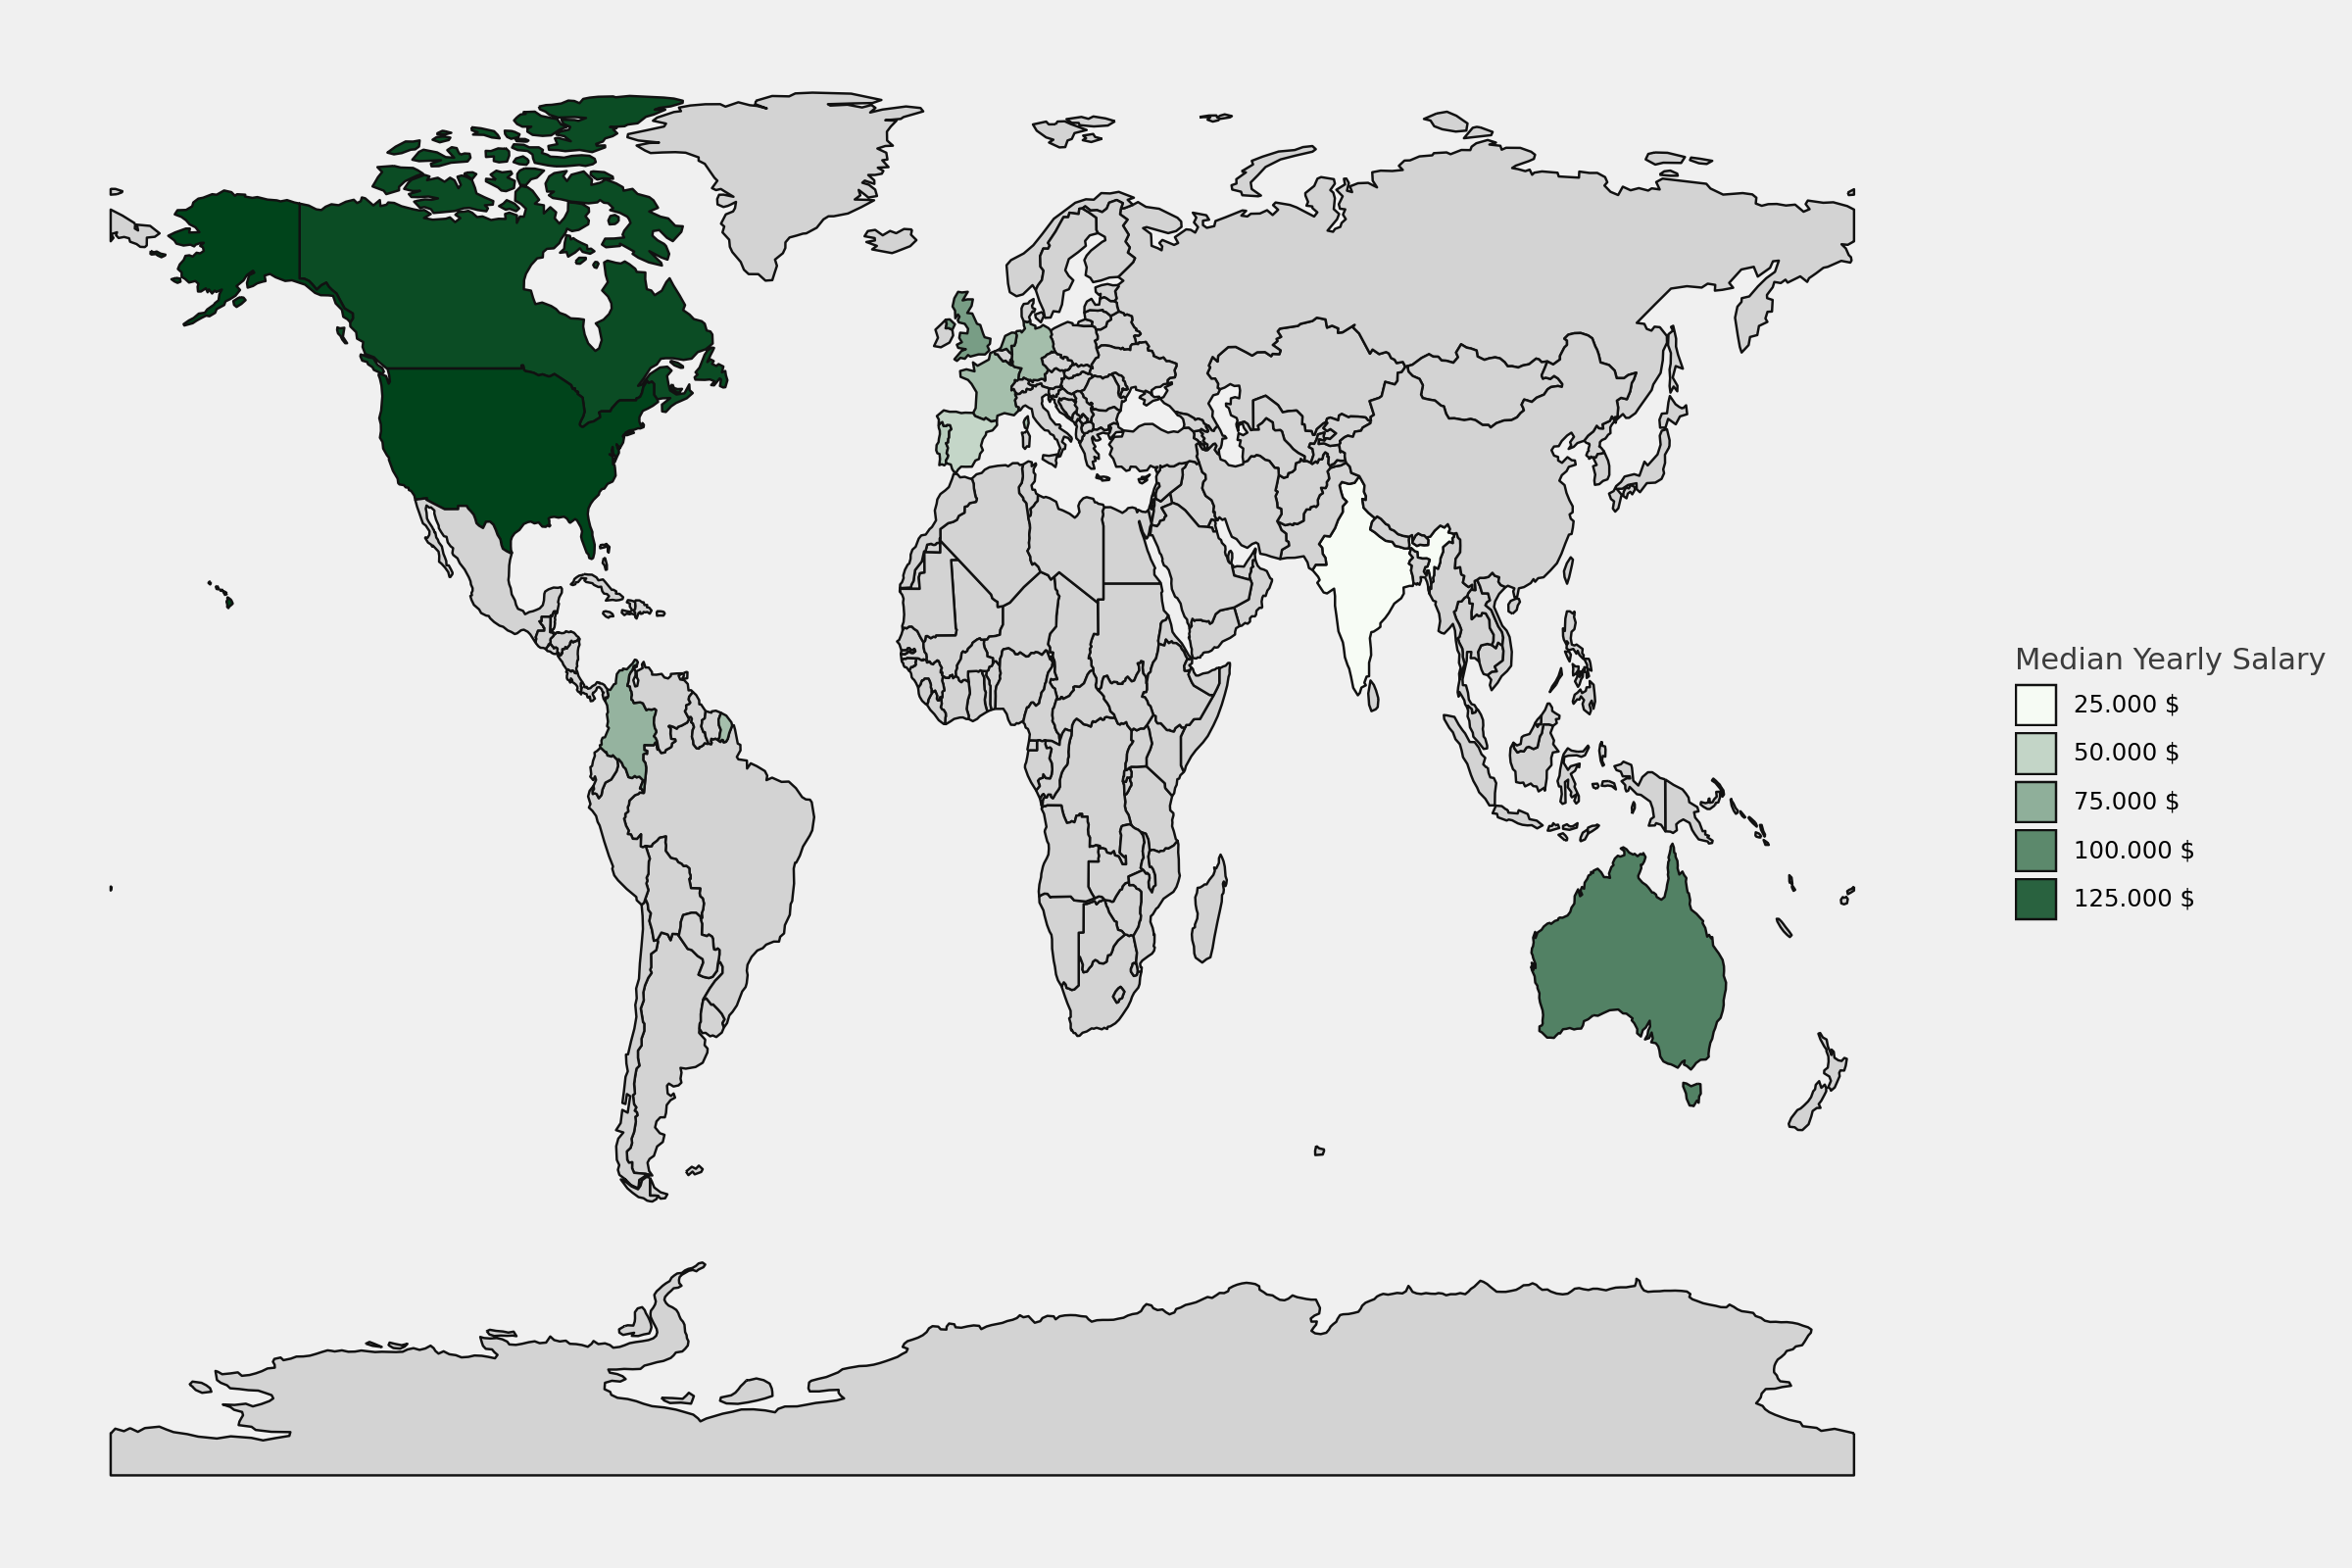

In [ ]:
def labeller1(x):
    return("{:,.0f} $".format(x).replace(",","."))

(
    ggplot(salary_median, aes(fill = "salary_in_usd"))
    + geom_map()
    + theme(figure_size=(12,8), axis_text_x=element_blank(), axis_text_y=element_blank(),panel_grid=element_blank())
    + scale_fill_gradient(name = "Median Yearly Salary", 
                          low = "#f7fcf5", high="#00441b", 
                          guide = "legend", 
                          na_value="lightgrey",
                          labels=lambda l: [labeller1(x) for x in l])
)

c:\Users\Marco\Desktop\Basics of computing\.data_science_salaries\.main\.venv\Lib\site-packages\plotnine\layer.py:293: PlotnineWarning: stat_boxplot : Removed 232 rows containing non-finite values.


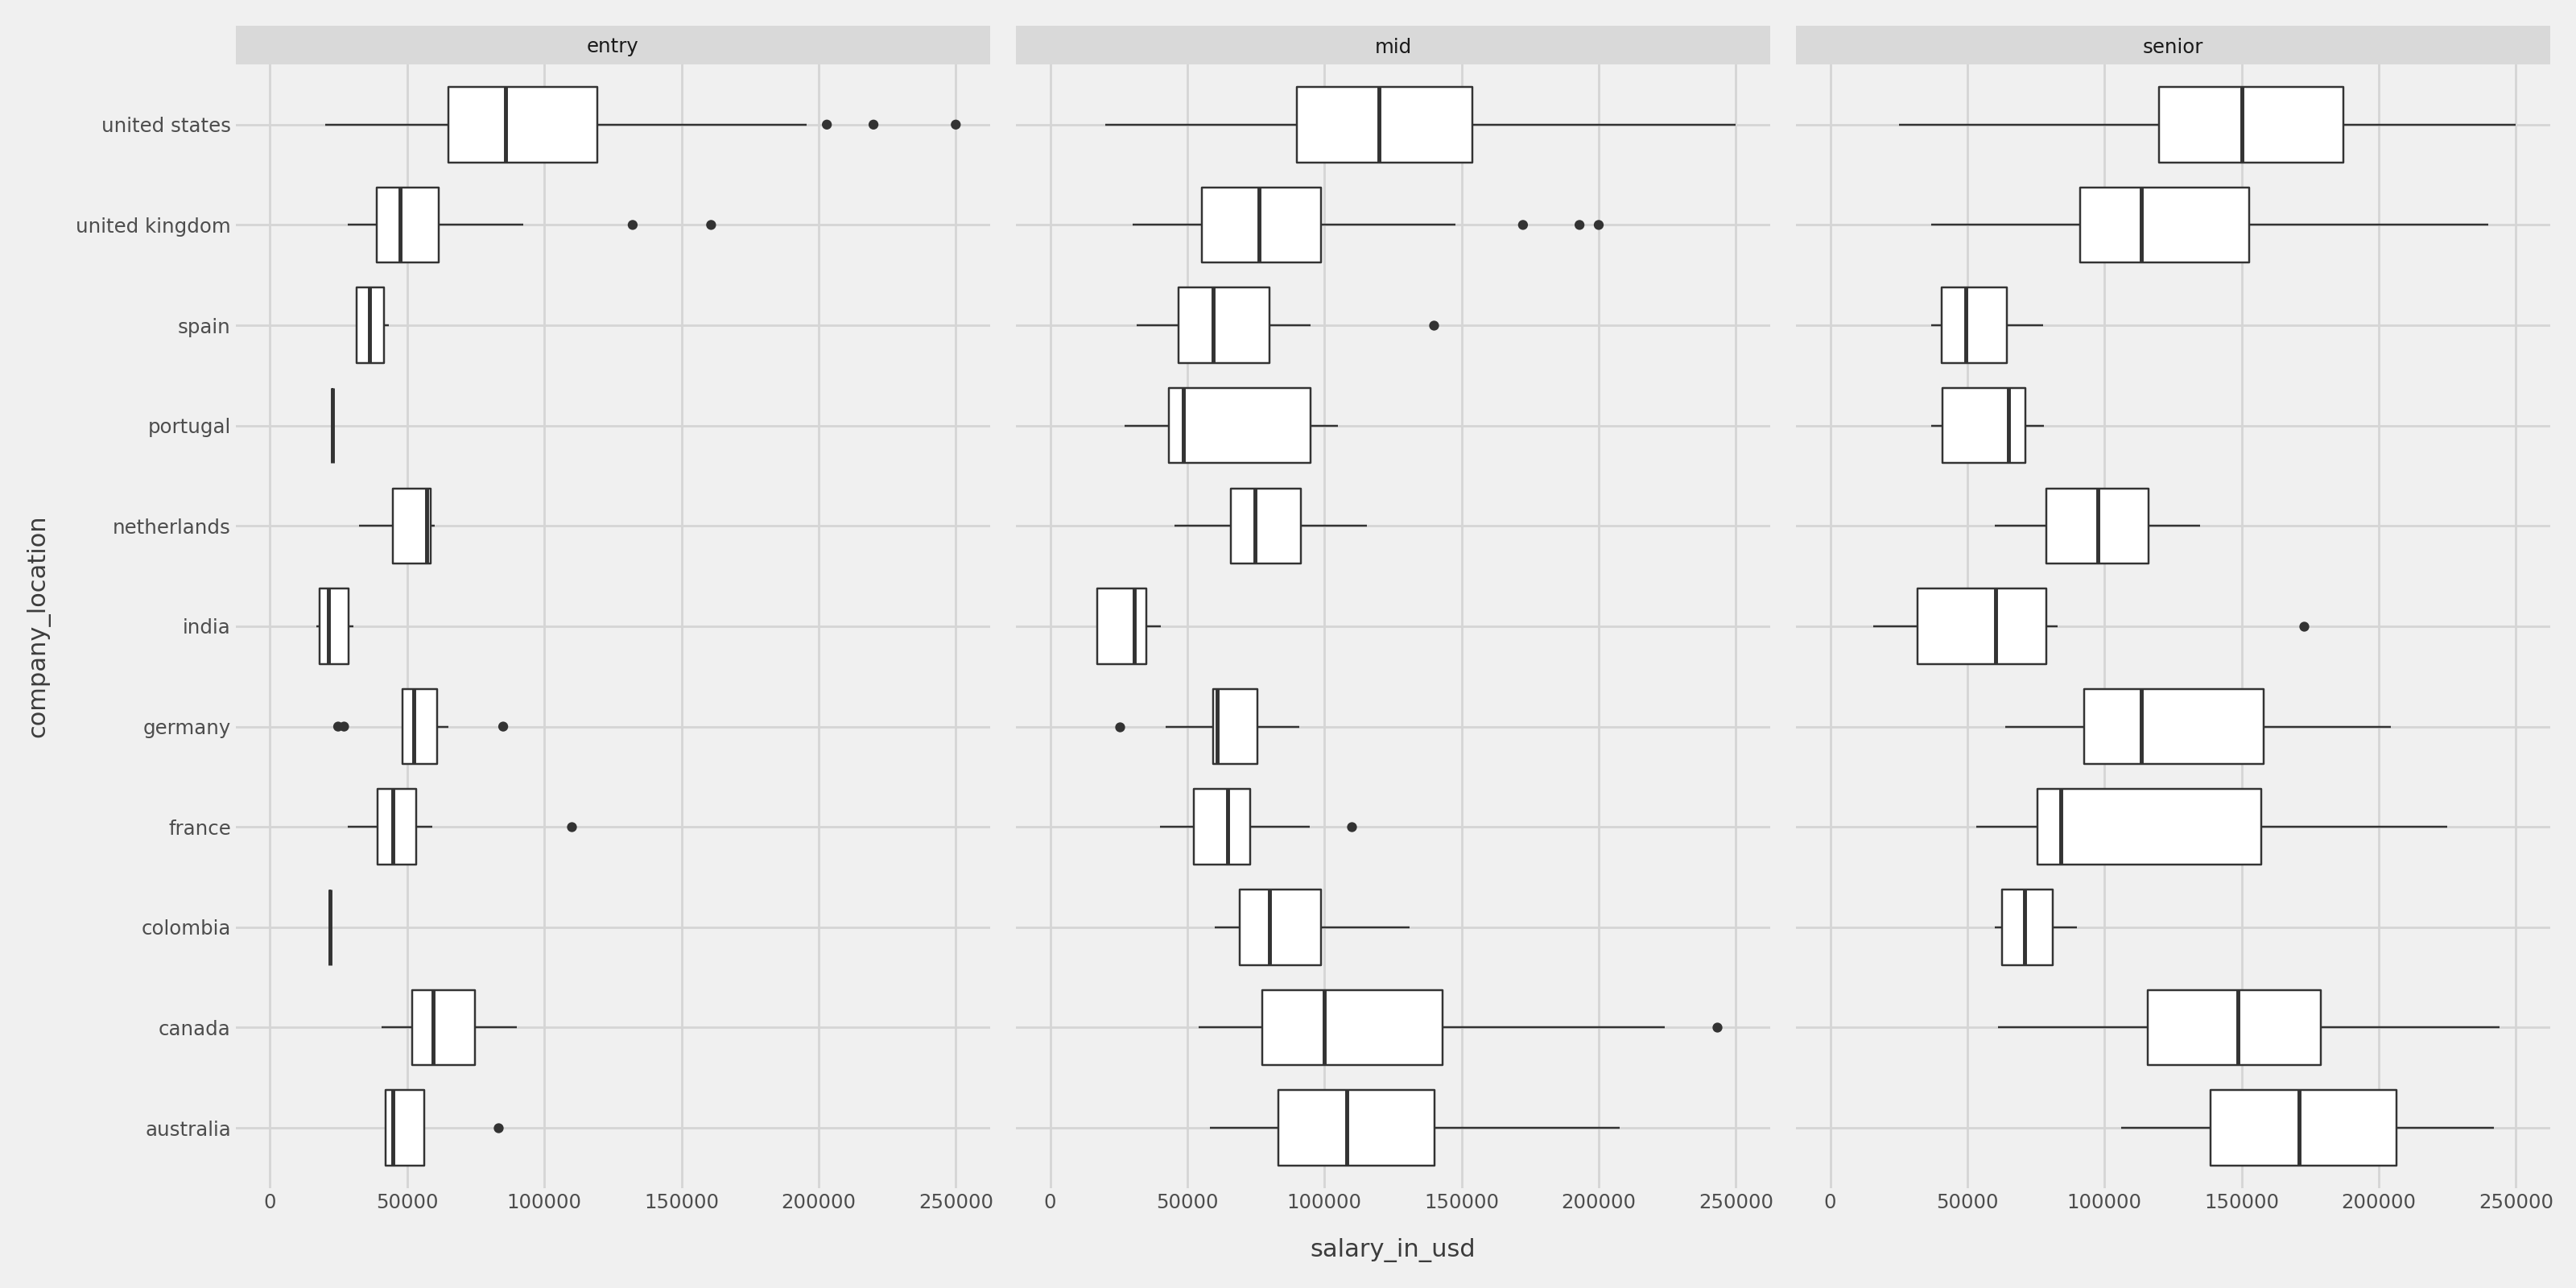

In [160]:
(
    ggplot(data[data["experience_level"] != "executive"], aes(x = 'company_location', y = 'salary_in_usd'))
    + ylim(0,250000)
    + facet_wrap("experience_level", nrow = 1)
    + geom_boxplot()
    + theme(figure_size=(16,8))
    + coord_flip()
)

In [161]:
remote_prop = data.groupby("matched_name")["work_models"].apply(lambda x: round(len(x[x == "remote"])/len(x) * 100, 2))
remote_prop = merge(remote_prop,gdf.loc[:,"ADMIN":"geometry"], how = "right", left_on = "matched_name", right_on = "ADMIN")

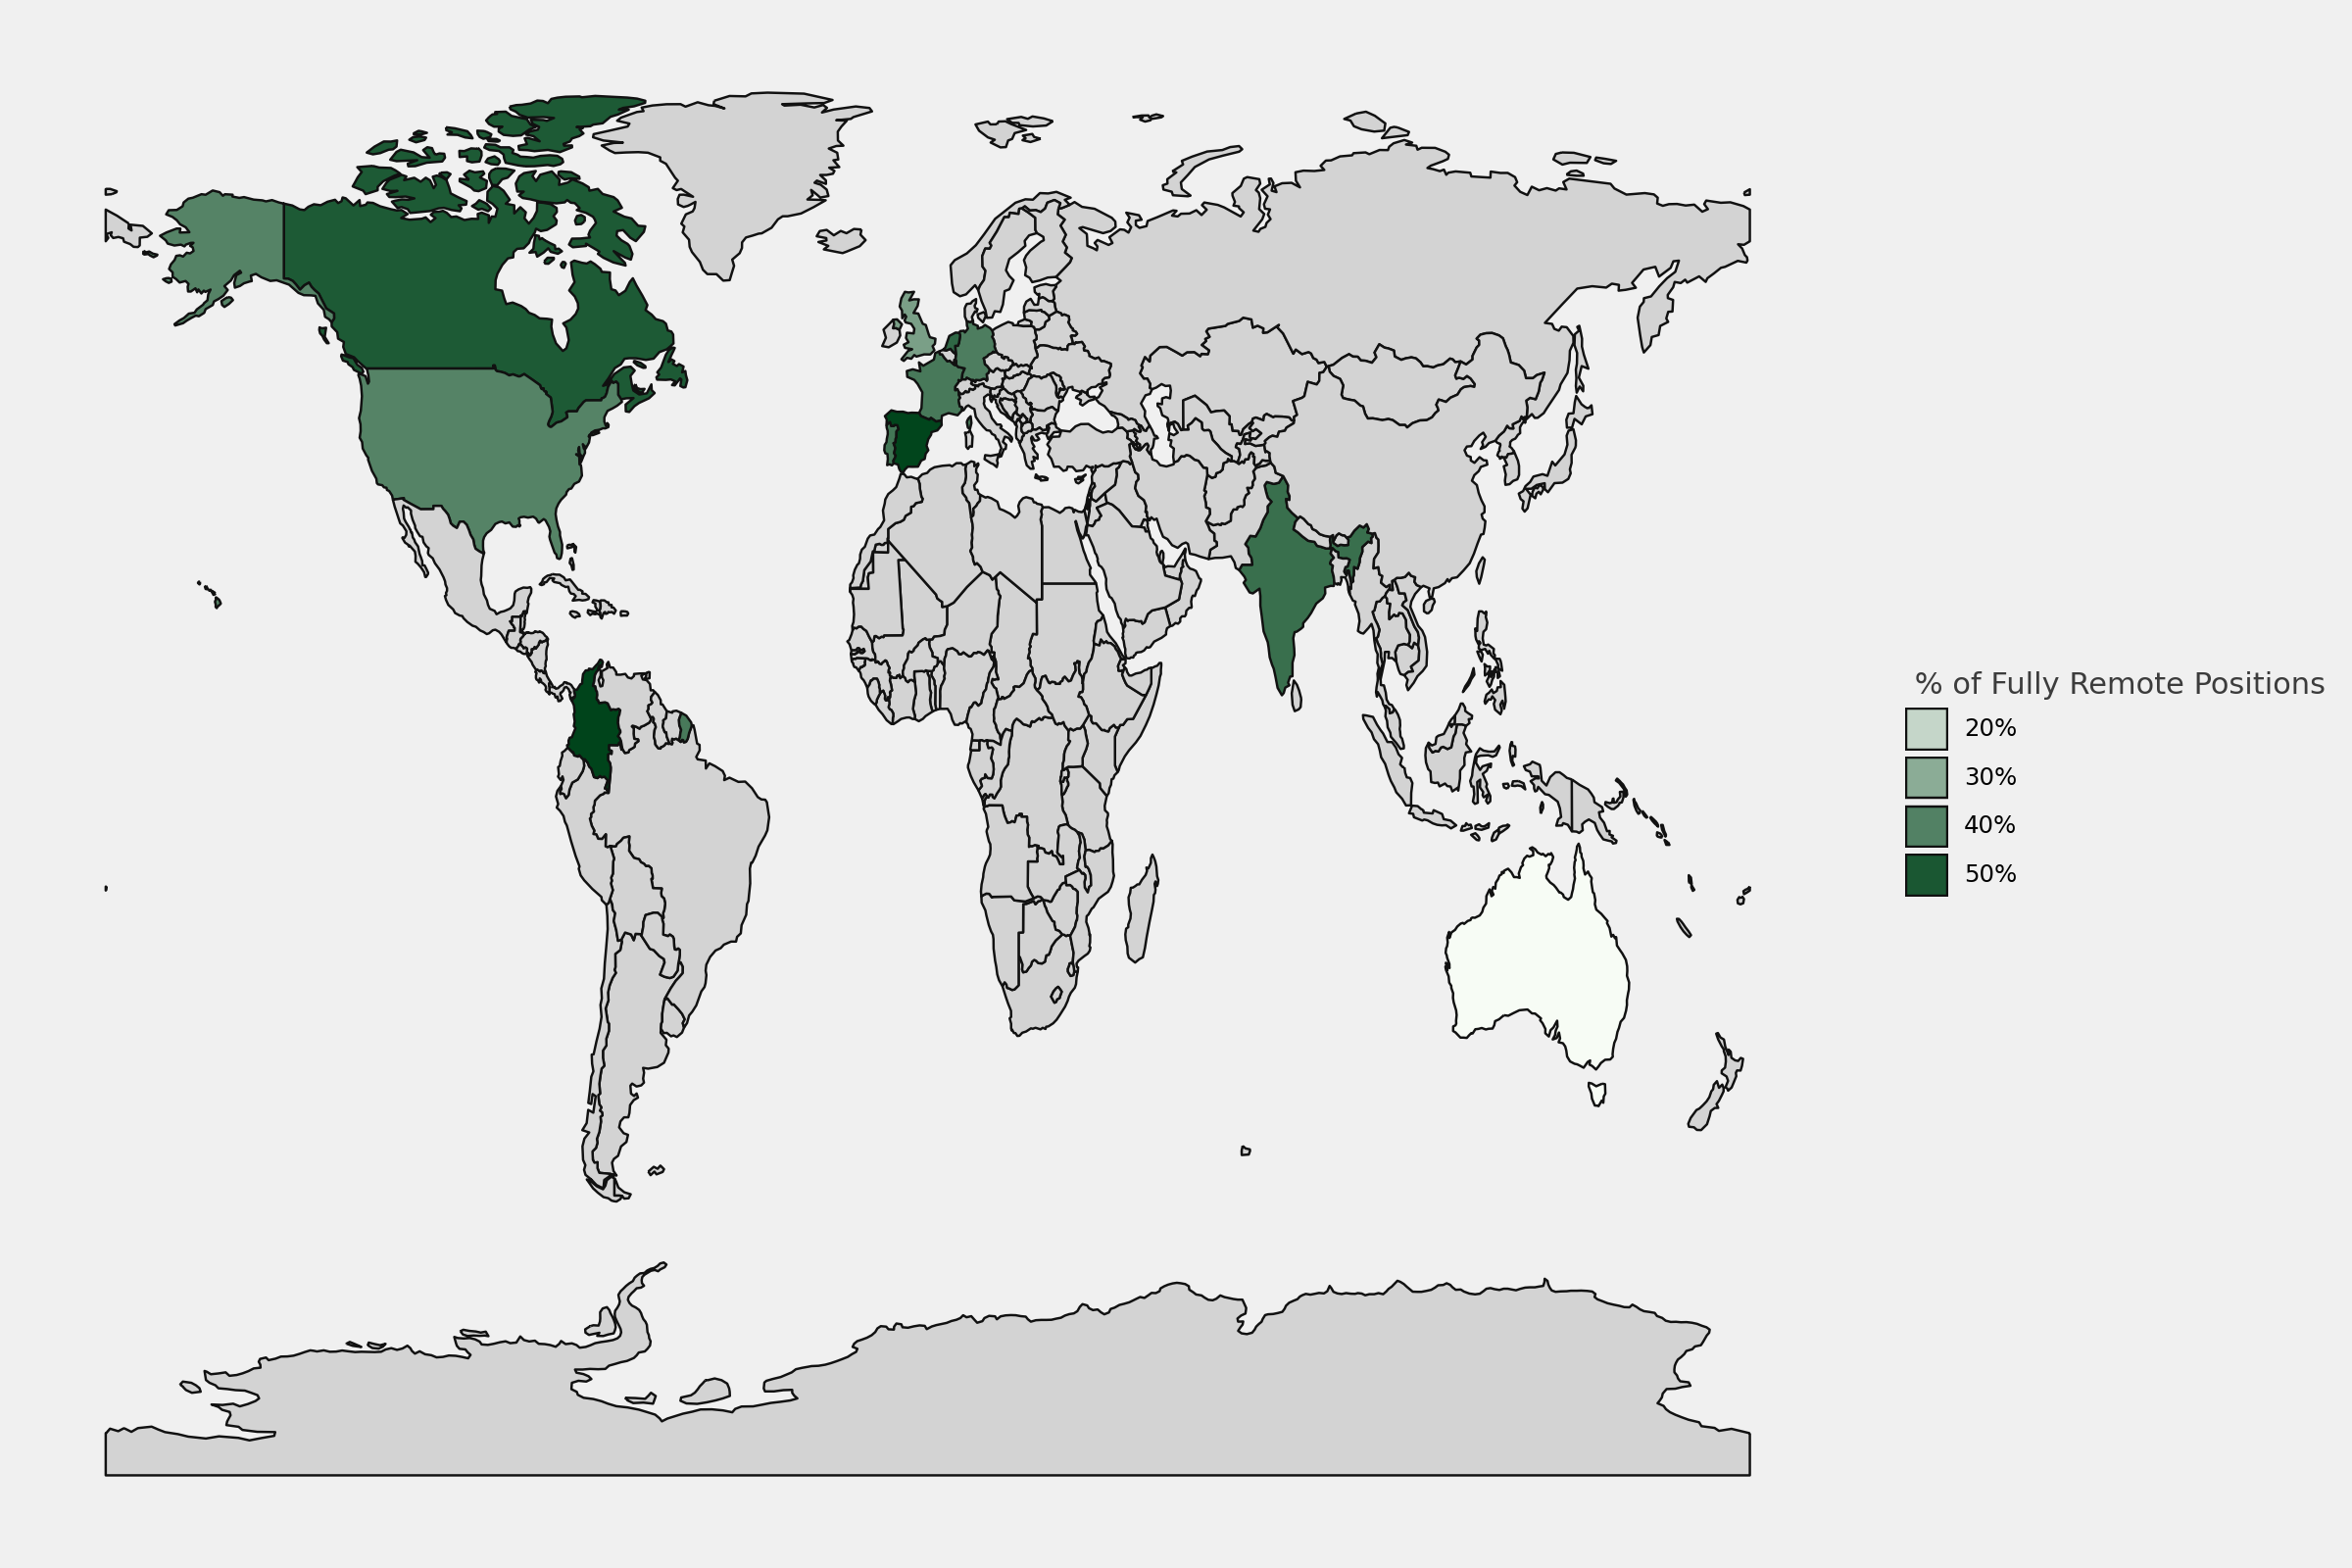

In [162]:
(
    ggplot(remote_prop, aes(fill = "work_models"))
    + geom_map()
    + theme(figure_size=(12,8), axis_text_x=element_blank(), axis_text_y=element_blank(),panel_grid=element_blank())
    + scale_fill_gradient(name = " % of Fully Remote Positions", 
                          low = "#f7fcf5", high="#00441b", 
                          guide = "legend", 
                          na_value="lightgrey", 
                          labels = ("20%","30%","40%","50%"))
)

In [167]:
usa_data = data[data["company_location"] == "united states"]
salaries_job_title= (usa_data.groupby(["job_title","work_year"]).median("salary_in_usd")).reset_index()

C:\Users\Marco\AppData\Local\Temp\ipykernel_27544\938668604.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [168]:
salaries_job_title

,job_title,work_year,salary,salary_in_usd
0,data analyst,2020,85000.0,85000.0
1,data analyst,2021,80000.0,80000.0
2,data analyst,2022,112900.0,112900.0
3,data analyst,2023,107187.5,107187.5
4,data analyst,2024,101893.0,101893.0
5,data engineer,2020,120400.0,120400.0
6,data engineer,2021,113500.0,113500.0
7,data engineer,2022,152000.0,152000.0
8,data engineer,2023,149076.0,149076.0
9,data engineer,2024,140000.0,140000.0


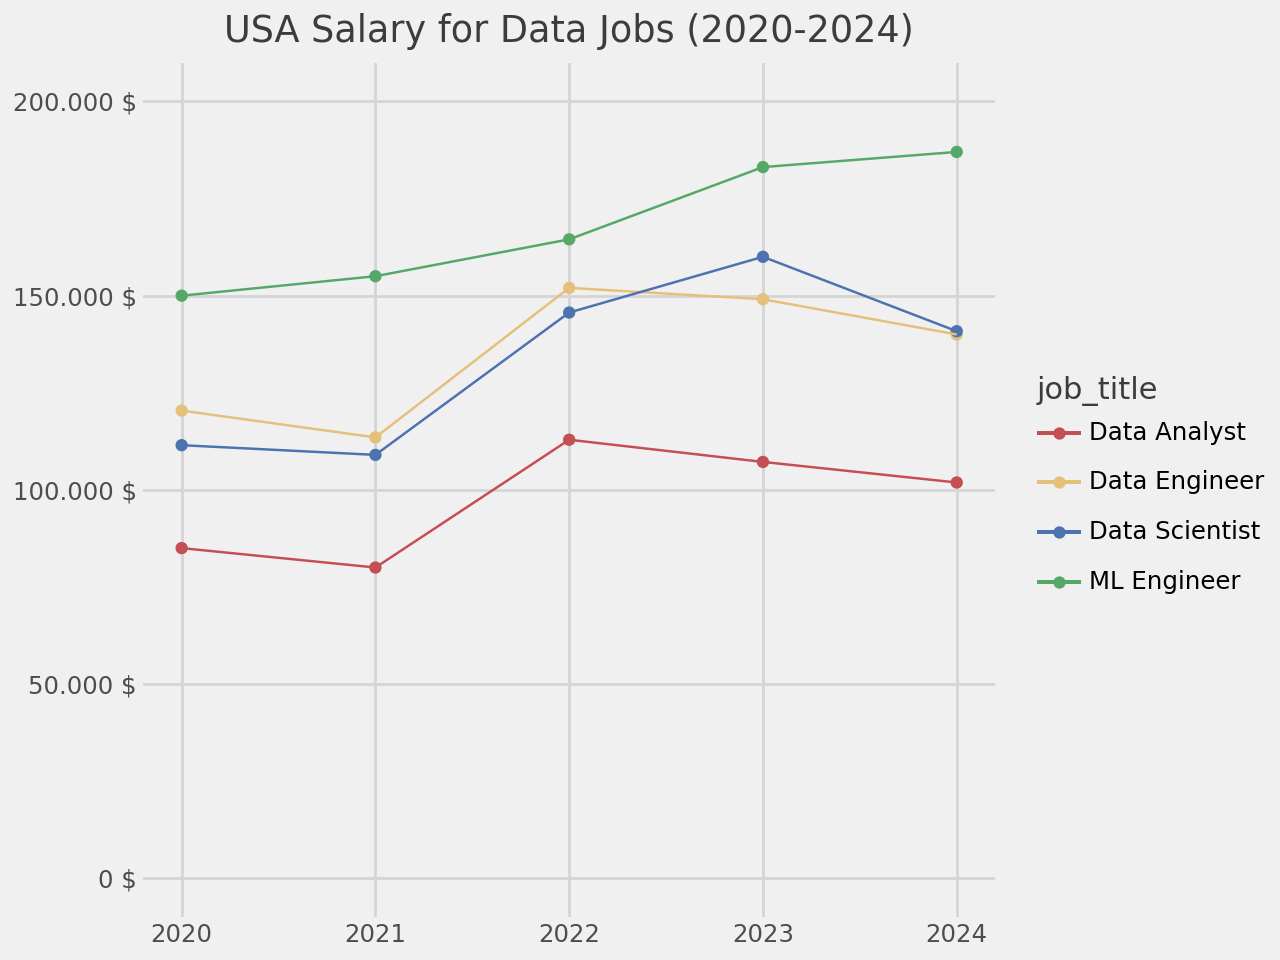

In [199]:

(
    ggplot(salaries_job_title, aes(x='work_year', y='salary_in_usd', color = 'job_title', group ='job_title')) 
    + geom_point()
    + geom_line()
    + scale_color_manual(cols, 
                         labels = ("Data Analyst", "Data Engineer", "Data Scientist", "ML Engineer"))
    + labs(title = "USA Salary for Data Jobs (2020-2024)", x = "",y = "")
    + scale_y_continuous(labels = lambda l: [labeller1(x) for x in l], limits = (0,200000)) 
)